In [1]:
"""
https://www.guru99.com/rnn-tutorial.html
"""
import numpy as np
import tensorflow as tf
n_inputs = 4
n_neurons = 6
n_timesteps = 2
## The data is a sequence of a number from 0 to 9 and divided into three batches of data.
## Data 
X_batch = np.array([
        [[0, 1, 2, 5], [9, 8, 7, 4]], # Batch 1
        [[3, 4, 5, 2], [0, 0, 0, 0]], # Batch 2
        [[6, 7, 8, 5], [6, 5, 4, 2]], # Batch 3
    ])

In [2]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_timesteps, n_inputs])

In [3]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [4]:
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [5]:
## Define the network
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    states_eval = states.eval(feed_dict={X: X_batch})
    print(states_eval)

[[ 0.9961891  -0.99932474 -0.94934744  0.9999446  -0.8161142  -0.9999993 ]
 [-0.3518163   0.18990113 -0.61935544  0.32122672 -0.8743417   0.7688221 ]
 [ 0.9216169  -0.8908221  -0.91109276  0.9972749  -0.91308814 -0.9973152 ]]


In [8]:
outputs[-1]

<tf.Tensor 'strided_slice:0' shape=(2, 6) dtype=float32>

In [7]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
ts= create_ts(start = '2001', n = 192, freq = 'M')
ts.tail(5)

2016-08-31    51.699221
2016-09-30    58.987115
2016-10-31    70.416032
2016-11-30    84.153576
2016-12-31    86.292081
Freq: M, dtype: float64

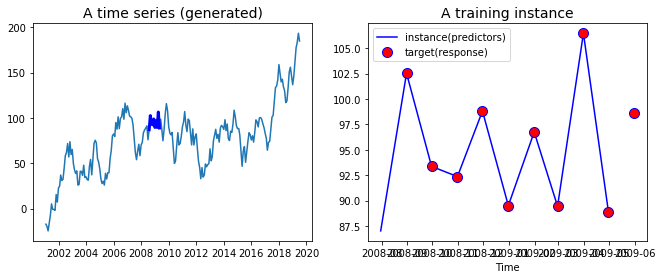

In [8]:
ts = create_ts(start = '2001', n = 222)
# Left
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(ts.index, ts)
plt.plot(ts.index[90:100], ts[90:100], "b-", linewidth=3, label="A training instance")
plt.title("A time series (generated)", fontsize=14)

# Right
plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(ts.index[90:100], ts[90:100], "b-", markersize=8, label="instance(predictors)")
plt.plot(ts.index[91:101], ts[91:101], "bo", markersize=10, label="target(response)", markerfacecolor='red')
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [23]:
series = np.array(ts)
n_windows = 20
n_input =  1
n_output = 1
size_train = 2001
print(series.shape)

(222,)


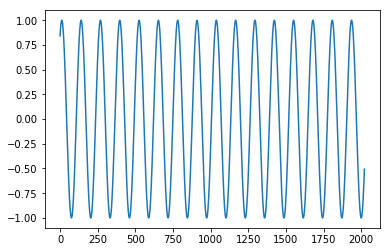

(2022,)
time: 169 ms


In [70]:
# Replace random data using sin wave
tag = np.linspace(1, 100, 2022)
values = np.sin(tag)
plt.plot(value)
plt.show() 
print(values.shape)

In [43]:
# Replace with real data.
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.extend(["../"])
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *
from pprint import pprint
pprint(UNRATE_DIR)
df = load_dataset(UNRATE_DIR["EC2"])
df_d1 = differencing(df, periods=1, order=1)

{'EC2': '/home/ec2-user/code/EFANN/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/EFANN/data/UNRATE.csv'}
Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


In [71]:
taken = len(df_d1) % (n_windows + 1)
size_train = 821
values = df_d1.values[taken-1:]
print(values.shape)

(841, 1)
time: 895 µs


In [73]:
train = values[:size_train]
test = values[size_train-1:]
print(train.shape, test.shape)

(821, 1) (21, 1)
time: 795 µs


In [76]:
# x_data = train[: size_train-1]
# x_batches = x_data.reshape(-1, n_windows, n_input)

def create_batches(df, windows, inputs, outputs):
    # Create X
    L = len(df)
    X_data = df[:L-1]
    X_batches = X_data.reshape(-1, windows, inputs)
    
    # Create y
    y_data = df[outputs:L]
    y_batches = y_data.reshape(-1, windows, outputs)
    
    return X_batches, y_batches

time: 885 µs


In [77]:
X_batches, y_batches = create_batches(
    df=train,
    windows=n_windows,
    inputs=n_input,
    outputs=n_output
)

X_test, y_test = create_batches(
    df=test,
    windows=n_windows,
    inputs=n_input,
    outputs=n_output
)

time: 743 µs


In [78]:
print(X_batches.shape, y_batches.shape)
print(X_test.shape, y_test.shape)

(41, 20, 1) (41, 20, 1)
(1, 20, 1) (1, 20, 1)
time: 637 µs


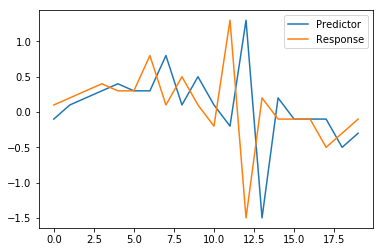

time: 165 ms


In [79]:
plt.plot(X_batches[0])
plt.plot(y_batches[0])
plt.legend(["Predictor", "Response"])
plt.show()

In [89]:
# Data feed
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_windows, n_input])
y = tf.placeholder(tf.float32, [None, n_windows, n_output])

time: 2.78 ms


In [90]:
r_neuron=128

time: 374 µs


In [91]:
# RNN
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=r_neuron, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)   

time: 72.8 ms


In [92]:
# ? look at this
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.layers.dense(stacked_rnn_output, n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])  

time: 17 ms


In [93]:
learning_rate = 0.03

time: 390 µs


In [94]:
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

# Operation
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 133 ms


(41, 20, 1)

time: 1.92 ms


In [105]:
iteration = 5000
with tf.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(f"Iteration [{iters}] MSE {mse:0.7f}")
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    y_pred_train = sess.run(outputs, feed_dict={X: X_batches})

Iteration [0] MSE 0.0499813
Iteration [150] MSE 0.0461395
Iteration [300] MSE 0.0433244
Iteration [450] MSE 0.0410829
Iteration [600] MSE 0.0394626
Iteration [750] MSE 0.0383395
Iteration [900] MSE 0.0375642
Iteration [1050] MSE 0.0369439
Iteration [1200] MSE 0.0363917
Iteration [1350] MSE 0.0359121
Iteration [1500] MSE 0.0354553
Iteration [1650] MSE 0.0350221
Iteration [1800] MSE 0.0345960
Iteration [1950] MSE 0.0341744
Iteration [2100] MSE 0.0337965
Iteration [2250] MSE 0.0334186
Iteration [2400] MSE 0.0330318
Iteration [2550] MSE 0.0326346
Iteration [2700] MSE 0.0322547
Iteration [2850] MSE 0.0318978
Iteration [3000] MSE 0.0315529
Iteration [3150] MSE 0.0312156
Iteration [3300] MSE 0.0308729
Iteration [3450] MSE 0.0305307
Iteration [3600] MSE 0.0301843
Iteration [3750] MSE 0.0298452
Iteration [3900] MSE 0.0295208
Iteration [4050] MSE 0.0292037
Iteration [4200] MSE 0.0288910
Iteration [4350] MSE 0.0285861
Iteration [4500] MSE 0.0282769
Iteration [4650] MSE 0.0279739
Iteration [4800] 

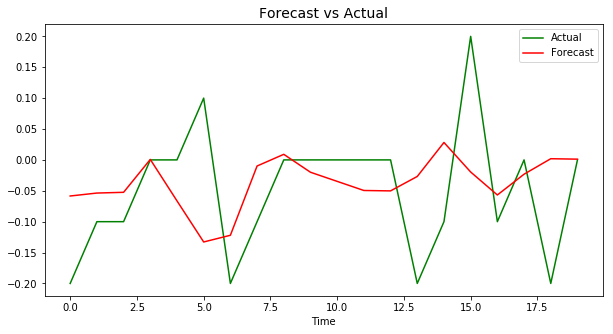

time: 207 ms


In [106]:
plt.figure(figsize=(10,5))
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "-", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "-", markersize=8, label="Forecast", color='red')
plt.legend(loc="best")
plt.xlabel("Time")

plt.show()

In [113]:
p = y_pred_train.reshape(-1, 1)
a = y_batches.reshape(-1, 1)

time: 517 µs


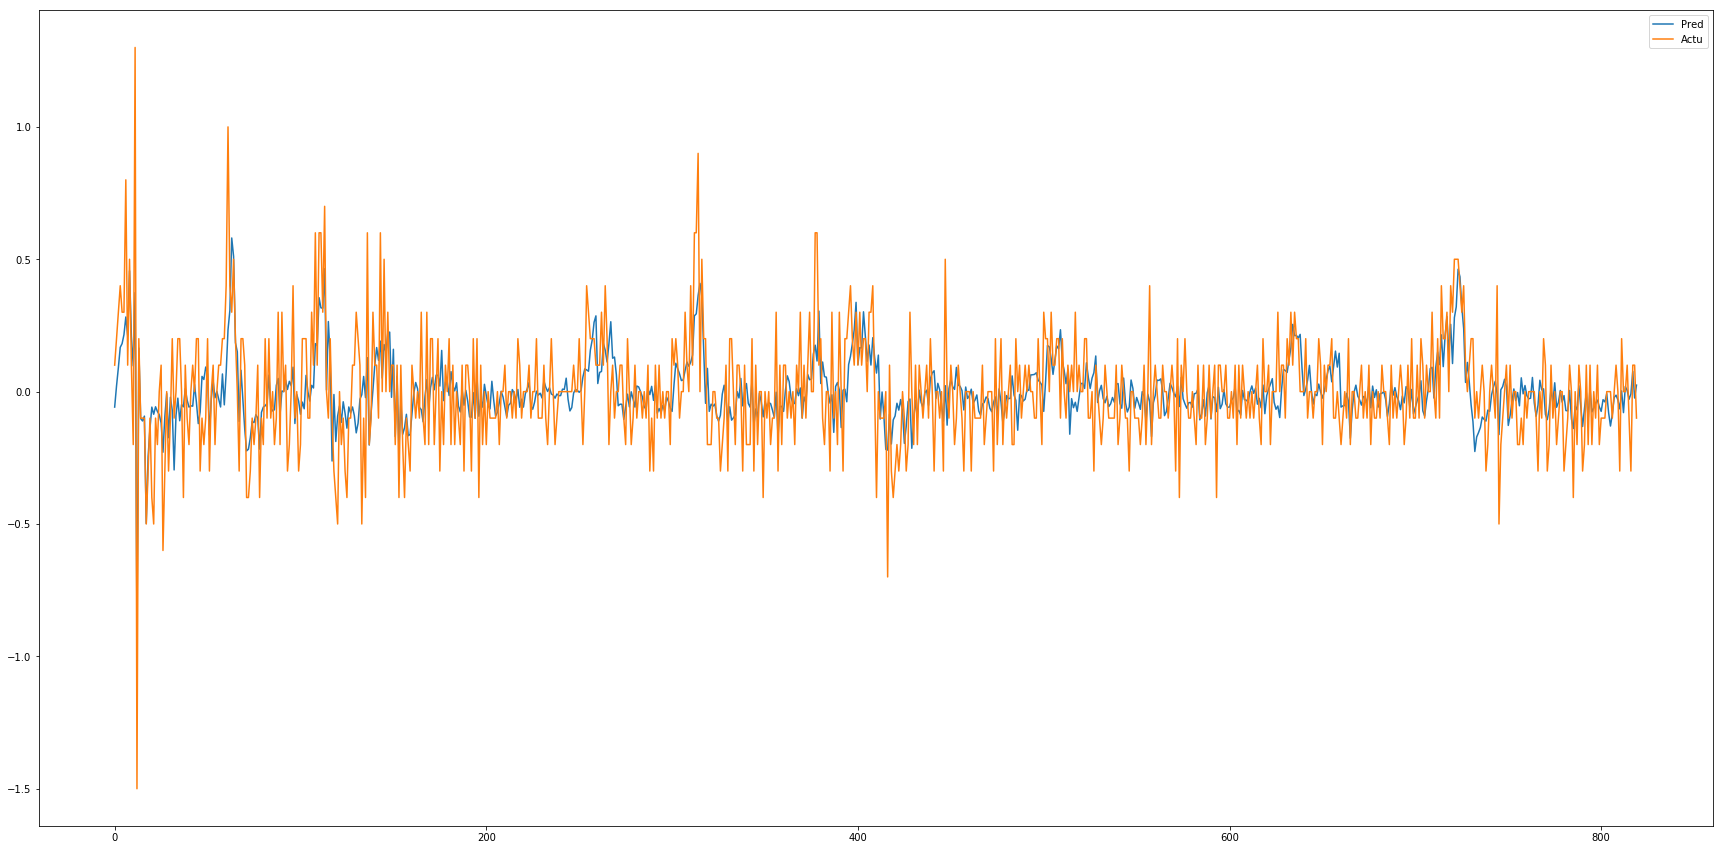

time: 618 ms


In [114]:
plt.figure(figsize=(30,15))
plt.plot(p)
plt.plot(a)
plt.legend(["Pred", "Actu"])
plt.show()